In [1]:
#Import Libraries
# Standard data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns  # Optional for more advanced visualizations

# Image processing library
import cv2

# Random number generation
import random

# File system interaction
import os

# Deep learning libraries
import keras
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam

# Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">Reading Dataset</h2>
</center>
  

In [2]:
# Path of the Dry Tea leaves data Set
path_of_dataset = '/kaggle/input/liquor-cnn-densenet201-mobilenetv2/Liquor'

In [3]:
# Assuming 'path_of_dataset' contains the root directory of your dataset

images = []
labels = []

# Iterate through subfolders within the dataset directory
for subfolder in os.listdir(path_of_dataset):
  # Check if the current item is a directory (skip non-directory items)
  if not os.path.isdir(os.path.join(path_of_dataset, subfolder)):
    continue

  # Construct the full path to the subfolder
  path_of_subfolder = os.path.join(path_of_dataset, subfolder)

  # Iterate through image files within the current subfolder
  for file_of_image in os.listdir(path_of_subfolder):
    # Construct the full path to the image file
    image_path = os.path.join(path_of_subfolder, file_of_image)

    # Append the image path to the 'images' list
    images.append(image_path)

    # Assign the subfolder name as the label (assuming each subfolder represents a class)
    labels.append(subfolder)

# Explanation:
#  - os.listdir(path): Lists all items (files and directories) within a given path.
#  - os.path.join(path1, path2, ...): Combines multiple path components into a single path.
#  - os.path.isdir(path): Checks if a path points to a directory.


In [4]:
# Create a DataFrame 'data' with columns 'image' and 'label' using the lists 'images' and 'labels'
data = pd.DataFrame({'image':images,'label':labels})
data.head()

,image,label
0,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...
1,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...
2,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...
3,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...
4,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...


In [5]:
# Get the unique class names from the 'label' column
class_names = data['label'].unique().tolist()
class_names

['LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strength - Not High Fired',
 'LG_OD_BOP1_Cup Coloury_Fair Colour_Fair Strength - Not High Fired',
 'MG_OD_FF1 -  Cup Colour_Little Plain_Fair Strength - Not High Fired',
 'MG_OD_BOPF -  Cup Colour_Coloury_Fair Strength - Not High Fired',
 'LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strength - High Fired',
 'MG_OD_BOP1 - Cup Colour_Little Plain_Lacking Strength - Not High Fired',
 'LG_OD_BOP1_Cup Colour_Fair Coloury_LIttle Harch - Not High Fired',
 'LG_OD_BOP1_Cup Colour_Fair Colour_Dull Strength - Not High Fired']

In [6]:
# Display information about the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1709 non-null   object
 1   label   1709 non-null   object
dtypes: object(2)
memory usage: 26.8+ KB


In [7]:
# Display descriptive statistics of the DataFrame
data.describe().T

,count,unique,top,freq
image,1709,1709,/kaggle/input/liquor-cnn-densenet201-mobilenet...,1
label,1709,8,LG_OD_BOP1_Cup Colour_Fair Colour_Dull Strengt...,262


In [8]:
# Create a DataFrame 'df_label' containing the counts of each label and reset index
df_label=data['label'].value_counts().to_frame().reset_index()
df_label

,label,count
0,LG_OD_BOP1_Cup Colour_Fair Colour_Dull Strengt...,262
1,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,232
2,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,210
3,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,208
4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,206
5,LG_OD_BOP1_Cup Coloury_Fair Colour_Fair Streng...,204
6,LG_OD_BOP1_Cup Colour_Fair Coloury_LIttle Harc...,194
7,MG_OD_FF1 - Cup Colour_Little Plain_Fair Stre...,193


In [9]:
# Display the last few rows of the DataFrame
data.tail()

,image,label
1704,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_BOP1_Cup Colour_Fair Colour_Dull Strengt...
1705,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_BOP1_Cup Colour_Fair Colour_Dull Strengt...
1706,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_BOP1_Cup Colour_Fair Colour_Dull Strengt...
1707,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_BOP1_Cup Colour_Fair Colour_Dull Strengt...
1708,/kaggle/input/liquor-cnn-densenet201-mobilenet...,LG_OD_BOP1_Cup Colour_Fair Colour_Dull Strengt...


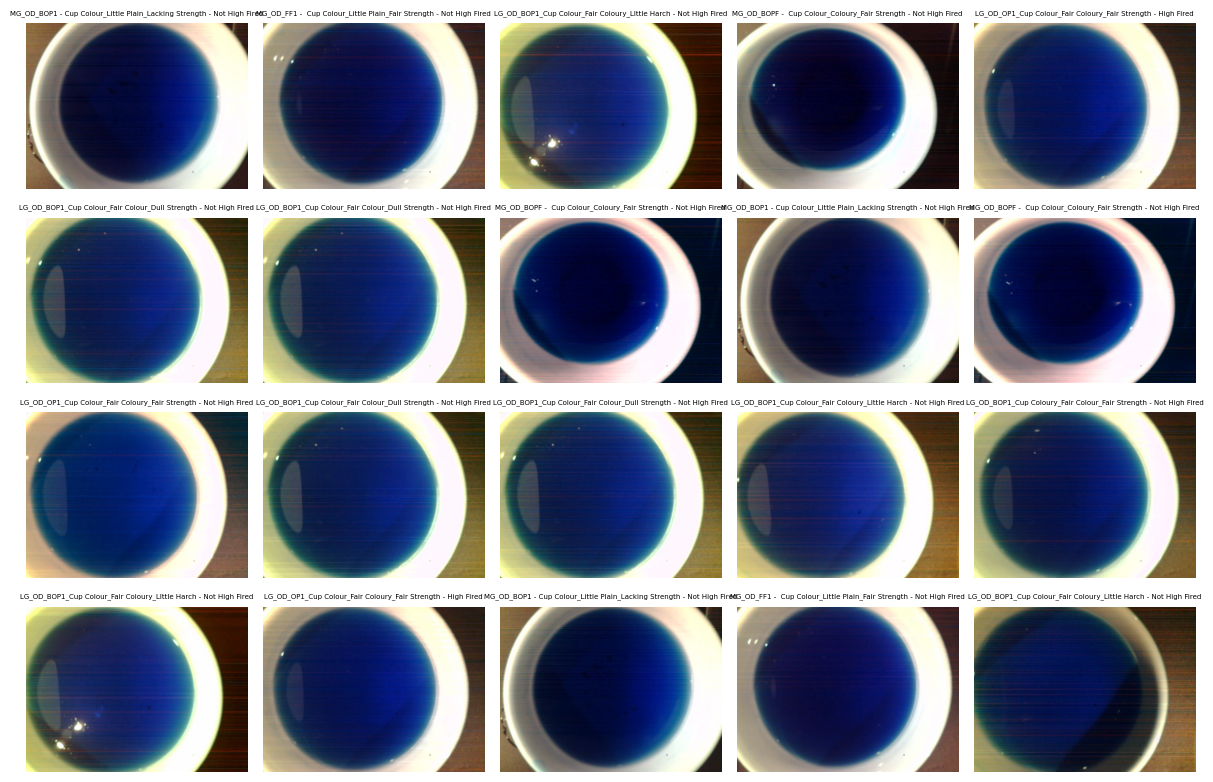

In [10]:
def display_random_images(data, num_images=20, figsize=(10, 10)):

  """Displays a grid of randomly selected images and labels from a pandas DataFrame.

  Args:
    data (pd.DataFrame): DataFrame containing 'image' (image paths) and 'label' columns.
    num_images (int, optional): Number of images to display (default: 20).
    figsize (tuple, optional): Size of the figure (default: (10, 10)).
    
  Raises:
    ValueError: If 'image' or 'label' columns are not found in the DataFrame.
  """

  if 'image' not in data.columns or 'label' not in data.columns:
    raise ValueError("DataFrame must contain 'image' and 'label' columns.")

  # Ensure num_images stays within DataFrame length
  num_images = min(len(data), num_images)

  # Randomly select image indices
  random_indices = np.random.choice(data.index, num_images, replace=False)

  # Calculate grid dimensions (optimized for efficiency)
  num_rows = int(np.ceil(num_images / 5)) # Use ceil to handle non-divisible cases
  num_cols = min(5, num_images) # Cap columns at 5 for better layout

  # Create a grid of subplots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

  # Loop over selected indices and display images
  for i, idx in enumerate(random_indices):
    img = cv2.imread(data.image.iloc[idx])
    axes.flat[i].imshow(img)
    axes.flat[i].axis('off') # Turn off axes for cleaner presentation
    axes.flat[i].set_title(data.label.iloc[idx], fontsize=5)

  # Adjust layout to prevent overlapping elements
  plt.tight_layout()
  plt.show()

# Example usage (assuming you have a DataFrame `data` with 'image' and 'label' columns)
display_random_images(data, num_images=20, figsize=(12, 8)) # Adjust as needed

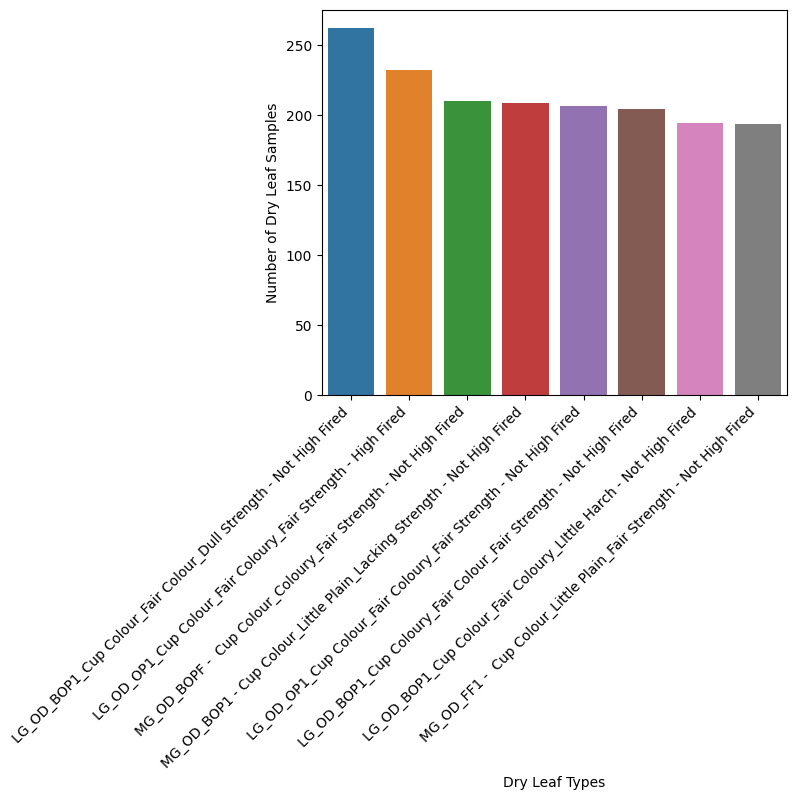

In [11]:
# Assuming you have 'df_label' DataFrame with 'label' and 'count' columns
plt.figure(figsize=(6, 5))
sns.barplot(data=df_label, x='label', y='count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees and right-align
plt.xlabel("Dry Leaf Types")
plt.ylabel("Number of Dry Leaf Samples")
plt.show()



<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">Splitting Dataset</h2>
</center>
  

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd
# Extract features (image data) and target labels from the DataFrame
x = data['image']
y = data['label']

# Split the data into training and testing sets (initial split)
x_train, x_test1, y_train, y_test1 = train_test_split(x, y, test_size=0.5, shuffle=True, random_state=45)

# Further split the testing set into validation and final testing sets
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.5, shuffle=True, random_state=45)

# Explanation of arguments:
#   test_size: Proportion of data for the testing set (0.5 for 50% here)
#   shuffle: Randomly shuffle the data before splitting (ensures no bias)
#   random_state: Seed for the random number generator (reproducibility)


In [13]:
# Print the shapes of the training, validation, and testing sets
print(f'The shape of x_train:{x_train.shape}')
print(f'The shape of x_test:{x_test.shape}')
print(f'The shape of x_val:{x_val.shape}')

print(f'The shape of y_train:{y_train.shape}')
print(f'The shape of y_test:{y_test.shape}')
print(f'The shape of y_val:{y_val.shape}')

The shape of x_train:(854,)
The shape of x_test:(428,)
The shape of x_val:(427,)
The shape of y_train:(854,)
The shape of y_test:(428,)
The shape of y_val:(427,)


In [14]:
# Create DataFrames for Training, Testing, and Validation Sets
train_df = pd.DataFrame({'image': x_train, 'label': y_train})
test_df = pd.DataFrame({'image': x_test, 'label': y_test})
validation_df = pd.DataFrame({'image': x_val, 'label': y_val})

# Print the shapes of the DataFrames
print(f'Shape of train_df (training data): {train_df.shape}')
print(f'Shape of test_df (final testing data): {test_df.shape}')
print(f'Shape of validation_df (validation data): {validation_df.shape}')


Shape of train_df (training data): (854, 2)
Shape of test_df (final testing data): (428, 2)
Shape of validation_df (validation data): (427, 2)




<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">Preprocessing</h2>
</center>
  


In [15]:
# Create a LabelEncoder instance (assuming use it multiple times)
label_encoder = LabelEncoder()

# Fit the encoder on the training labels (learns the mapping)
y_train = label_encoder.fit_transform(y_train)

# Transform the testing and validation labels using the fitted encoder
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [16]:
Image_size = 224 # Define the size of the images
# Define the input shape for the neural network
input_shape = (224,224,3) # Height, width, and number of channels (RGB)
Batch_size=32 # Define the batch size for training the neural network

In [17]:
from keras.preprocessing.image import ImageDataGenerator

# Specific augmentations suitable for tea liquor images (consider adjusting based on dataset characteristics)
img_gen = ImageDataGenerator(
    rescale=0.1/255,  # Normalize pixel values to [0, 1]
    featurewise_center=False,  # May not be necessary for tea liquor images (experiment)
    featurewise_std_normalization=False,  # May not be necessary for tea liquor images (experiment)
    rotation_range=15,  # Reduce rotation range (too much might distort tea appearance)
    width_shift_range=0.1,  # Adjust horizontal shift for tea image size
    height_shift_range=0.1,  # Adjust vertical shift for tea image size
    shear_range=0.1,  # Reduce shear range for subtle distortions
    zoom_range=0.1,  # Reduce zoom range for minor variations
    horizontal_flip=True,  # Maintain horizontal flip for tea liquor images
    fill_mode='nearest'  # Use nearest neighbor for filling empty pixels during transformations
)


In [18]:
train_gen = img_gen.flow_from_dataframe(train_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=True,class_mode='categorical')

test_gen = img_gen.flow_from_dataframe(test_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=False,class_mode='categorical')

val_gen = img_gen.flow_from_dataframe(validation_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=True,class_mode='categorical')

Found 854 validated image filenames belonging to 8 classes.
Found 428 validated image filenames belonging to 8 classes.
Found 427 validated image filenames belonging to 8 classes.




<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">Show our generator work</h2>
</center>
  


In [19]:
# Show the Generated Work
example_df = train_df.sample(n=32).reset_index(drop=True)
example_generator = img_gen.flow_from_dataframe(example_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=True,class_mode='categorical')



Found 32 validated image filenames belonging to 8 classes.


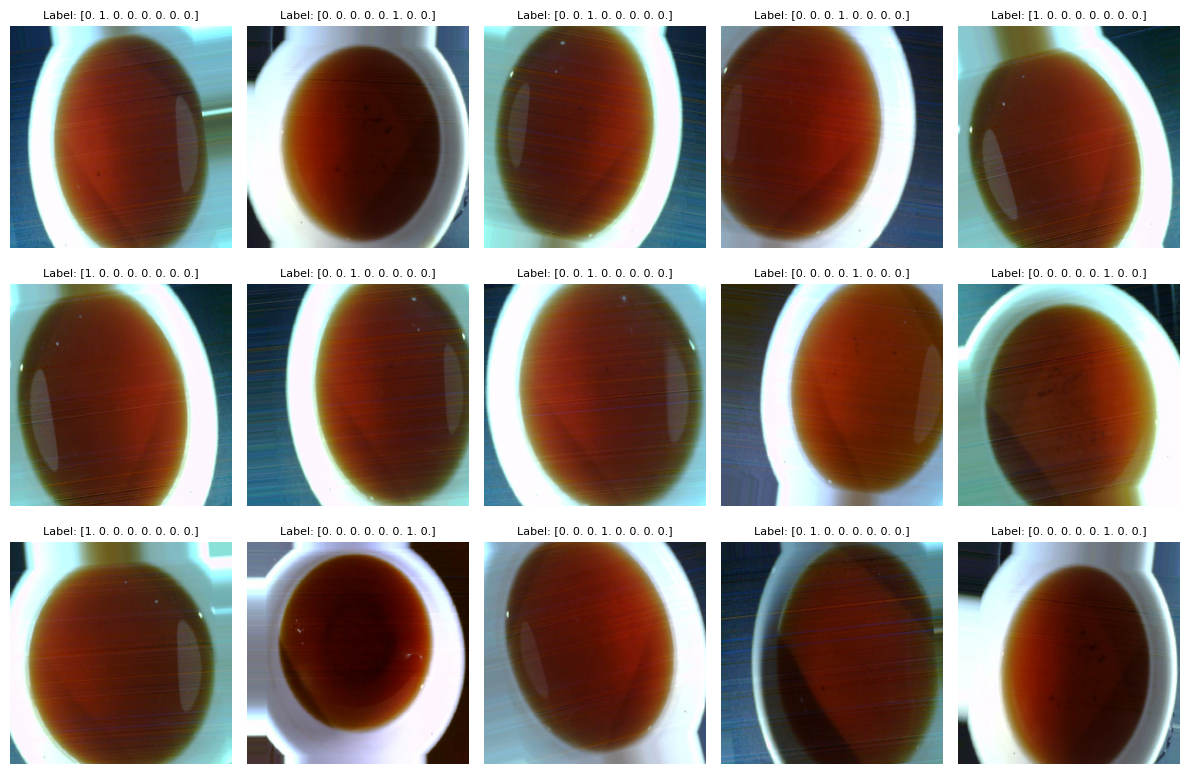

In [20]:
def visualize_data_augmentation(data_generator, num_images=15):
  """Visualizes data augmentation applied by a data generator.

  Args:
      data_generator: An ImageDataGenerator instance.
      num_images: Number of images to display (default: 15).
  """

  plt.figure(figsize=(12, 8))  # Adjusted figure size for better viewing

  for i in range(num_images):
    plt.subplot(3, 5, i + 1)

    # Get a batch of images and labels (assuming labels are available)
    x_batch, y_batch = next(data_generator)
    img = x_batch[0]

    # Normalize the image (assuming pixel values between 0 and 255)
    img = img.astype('float32')  # Convert to float for calculations
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Min-Max normalization

    # Display the image
    plt.imshow(img, cmap='viridis', interpolation='lanczos', vmin=0.2, vmax=0.8)
    plt.axis('off')

    # Optionally, display the label for overfitting analysis:
    if y_batch is not None:
      label = y_batch[0]  # Assuming labels are the first element in the batch
      plt.title(f"Label: {label}", fontsize=8)  # Add title with label

  plt.tight_layout()
  plt.show()


# Assuming example_generator is your ImageDataGenerator instance
visualize_data_augmentation(example_generator)





<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">CNN Model</h2>
</center>


In [21]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64,(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dense(8,activation='softmax'))


cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

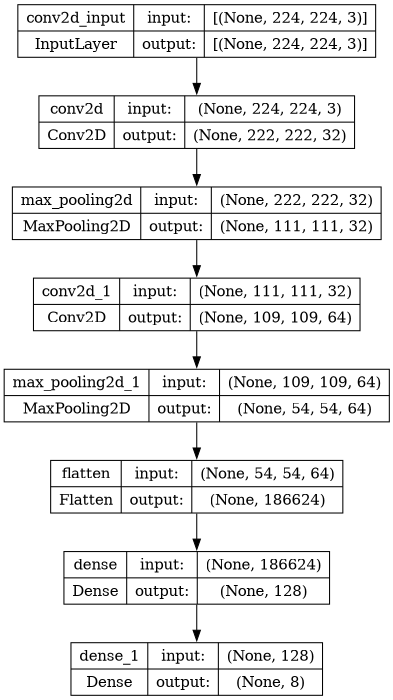

In [22]:
from tensorflow.keras.utils import plot_model
# Generate a visualization of the CNN model architecture
plot_model(cnn_model, to_file='model.png', 
           show_shapes=True, show_layer_names=True, 
           rankdir='TB', 
           dpi=75) # The resolution of the output image in dots per inch

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping callback 
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy for early stopping
    patience=20,  # Stop training if validation accuracy doesn't improve for 10 epochs
    verbose=1,  # Print a message at the end of each epoch
    restore_best_weights=True  # Restore best weights from the epoch with highest validation accuracy
)

# Define learning rate reduction callback with explanatory comments
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy for learning rate reduction
    patience=20,  # Reduce learning rate if validation accuracy doesn't improve for 10 epochs
    verbose=1,  # Print a message at the end of each epoch
    factor=0.1,  # Reduce learning rate by 10% each time
    min_lr=0.00001,  # Set a minimum learning rate to prevent excessive reduction
    mode='max'  # Monitor for maximization (as we're interested in improving accuracy)
)

# Combine callbacks in a list
callbacks = [early_stopping, learning_rate_reduction]
cnn_model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
# Train the model for 20 epochs
num_epochs1 = 20

# Train the model using fit_generator with validation data and callbacks
history1 = cnn_model.fit(
    train_gen,
    epochs=num_epochs1,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
27/27 [==============================] - 26s 821ms/step - loss: 2.0206 - accuracy: 0.2260 - val_loss: 1.7645 - val_accuracy: 0.3232 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - 18s 670ms/step - loss: 1.4535 - accuracy: 0.4098 - val_loss: 1.2324 - val_accuracy: 0.5644 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - 18s 677ms/step - loss: 1.1021 - accuracy: 0.5703 - val_loss: 1.0051 - val_accuracy: 0.6323 - lr: 0.0010
Epoch 4/20
27/27 [==============================] - 19s 702ms/step - loss: 0.9156 - accuracy: 0.6358 - val_loss: 0.7532 - val_accuracy: 0.7588 - lr: 0.0010
Epoch 5/20
27/27 [==============================] - 22s 829ms/step - loss: 0.7834 - accuracy: 0.7014 - val_loss: 0.6820 - val_accuracy: 0.7213 - lr: 0.0010
Epoch 6/20
27/27 [==============================] - 18s 672ms/step - loss: 0.6356 - accuracy: 0.7799 - val_loss: 0.5749 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 7/20
27/27 [==============================] - 18s 676ms/st

In [25]:
# Save the CNN Model
cnn_model.save("cnn_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">Evaluation</h2>
</center>


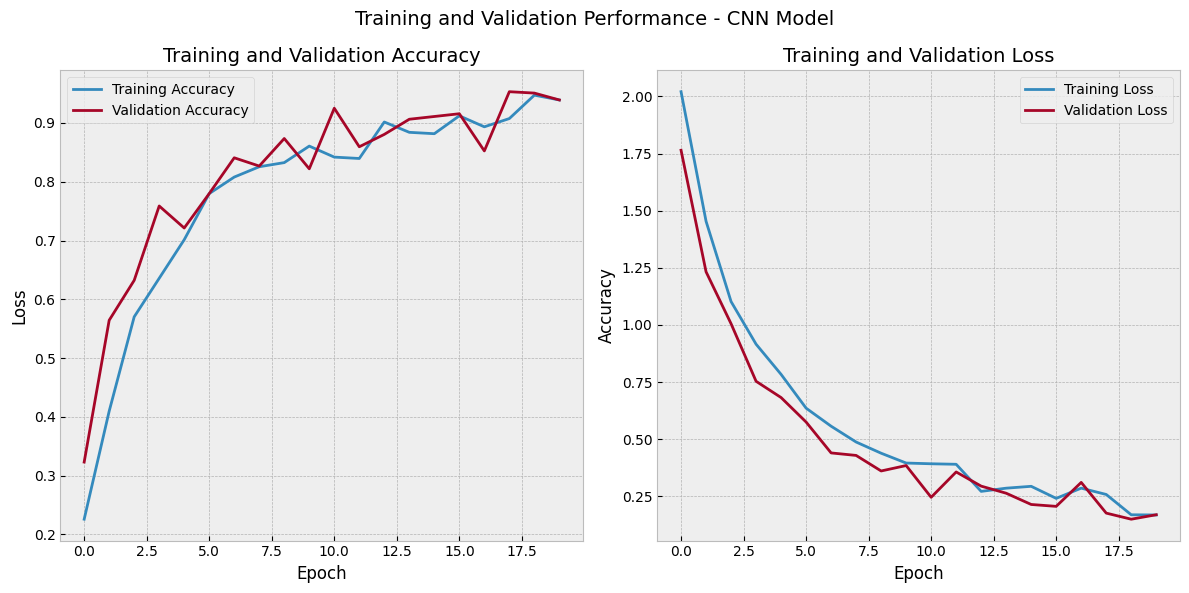

In [26]:
 # Assuming history_DenseNet contains the training history
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(num_epochs1)

# Improved labels for markers
#marker_fontsize = 10
plt.rcParams['font.size'] = 10

# Plot training history
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.style.use('bmh')  # Optional style

plt.suptitle('Training and Validation Performance - CNN Model', fontsize=14)

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
# Get true labels (classes) from the data generator
y_true = test_gen.classes
# Make predictions on the test data
y_pred = cnn_model.predict(test_gen)
# Select the class with the highest probability for each prediction
y_pred = np.argmax(y_pred, axis=1)  # Extract class labels from predictions

14/14 [==============================] - 7s 524ms/step


In [28]:
test_loss,test_accuracy = cnn_model.evaluate(test_gen)
print(f'test loss is : {test_loss}')
print(f'test accuracy is : {test_accuracy}')

14/14 [==============================] - 6s 422ms/step - loss: 0.1386 - accuracy: 0.9486
test loss is : 0.138645738363266
test accuracy is : 0.9485981464385986


In [29]:
predictions = cnn_model.predict(test_gen)
y_pred = np.argmax(predictions,axis=1)
y_test =test_gen.classes
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

df = pd.DataFrame({'Actual':y_test,'Prediction':y_pred})
df

14/14 [==============================] - 6s 427ms/step


,Actual,Prediction
0,5,5
1,5,5
2,4,4
3,6,6
4,4,4
...,...,...
423,5,5
424,0,0
425,5,5
426,1,1


In [30]:
classes = dict(zip(test_gen.class_indices.values(), test_gen.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_gen.labels))), 
                            "Test Labels" : test_gen.labels, 
                            "Test Classes" : [classes[i] for i in test_gen.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_gen.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(cnn_model.predict(test_gen), axis = 1))]
                           })
Predictions.head(8)

14/14 [==============================] - 6s 419ms/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.981898
1,1,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.999956
2,2,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.939991
3,3,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,1.000000
4,4,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.985911
5,5,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.993035
6,6,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.987494
7,7,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,1.000000


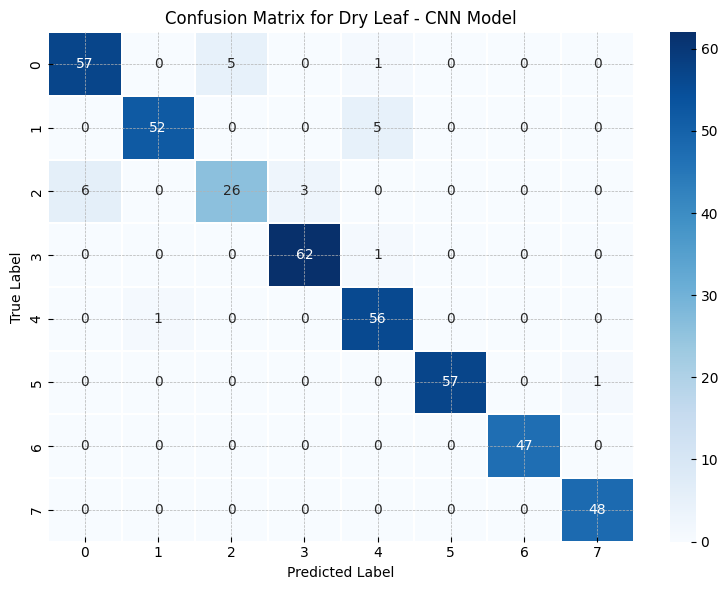

array([[57,  0,  5,  0,  1,  0,  0,  0],
       [ 0, 52,  0,  0,  5,  0,  0,  0],
       [ 6,  0, 26,  3,  0,  0,  0,  0],
       [ 0,  0,  0, 62,  1,  0,  0,  0],
       [ 0,  1,  0,  0, 56,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 57,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 47,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 48]])

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you have y_test (true labels) and y_pred (predicted labels)
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues',  linewidths=0.3)

plt.xlabel('Predicted Label',fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.title('Confusion Matrix for Dry Leaf - CNN Model',fontsize=12)
plt.tight_layout()
plt.show()

cm # from txt apperance

In [32]:
# Evaluate model performance
print("Classification Report:")
print(classification_report(y_true, y_pred))


classification_report = classification_report(y_test, y_pred, output_dict=True)
# Access and format desired metrics
precision = classification_report['weighted avg']['precision']
recall = classification_report['weighted avg']['recall']
f1_score = classification_report['weighted avg']['f1-score']
accuracy = classification_report['accuracy']
print(f"Weighted Average Performance:\n")
print(f"Precision: {precision:.4f}")  # Format with 4 decimal places
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        63
           1       0.98      0.91      0.95        57
           2       0.84      0.74      0.79        35
           3       0.95      0.98      0.97        63
           4       0.89      0.98      0.93        57
           5       1.00      0.98      0.99        58
           6       1.00      1.00      1.00        47
           7       0.98      1.00      0.99        48

    accuracy                           0.95       428
   macro avg       0.94      0.94      0.94       428
weighted avg       0.95      0.95      0.95       428

Weighted Average Performance:

Precision: 0.9464
Recall: 0.9463
F1-Score: 0.9456
Accuracy: 0.9463




<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">MobileNetV2 Model</h2>
</center>


In [33]:
model_MobileNet =tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)
model_MobileNet.trainable = False
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = model_MobileNet(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(8,activation='softmax')(x)

model_MobileNet = tf.keras.Model(inputs=[input_layer],outputs=[output])
model_MobileNet.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              64226304  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 8)                 8200     

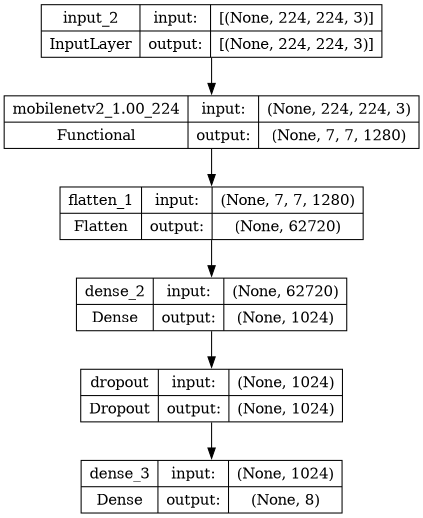

In [34]:
# Generate a visualization of the MobileNetV2 model architecture
plot_model(model_MobileNet, to_file='model.png', 
           show_shapes=True, show_layer_names=True, 
           rankdir='TB', 
           dpi=75) # The resolution of the output image in dots per inch

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping callback 
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy for early stopping
    patience=20,  # Stop training if validation accuracy doesn't improve for 10 epochs
    verbose=1,  # Print a message at the end of each epoch
    restore_best_weights=True  # Restore best weights from the epoch with highest validation accuracy
)

# Define learning rate reduction callback with explanatory comments
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy for learning rate reduction
    patience=20,  # Reduce learning rate if validation accuracy doesn't improve for 10 epochs
    verbose=1,  # Print a message at the end of each epoch
    factor=0.1,  # Reduce learning rate by 10% each time
    min_lr=0.00001,  # Set a minimum learning rate to prevent excessive reduction
    mode='max'  # Monitor for maximization (as we're interested in improving accuracy)
)

# Combine callbacks in a list
callbacks = [early_stopping, learning_rate_reduction]
model_MobileNet.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Train the model for 20 epochs
num_epochs = 20

# Train the model using fit_generator with validation data and callbacks
history_mobile = model_MobileNet.fit(
    train_gen,
    epochs=num_epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
27/27 [==============================] - 25s 783ms/step - loss: 36.2835 - accuracy: 0.3138 - val_loss: 8.9192 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - 18s 672ms/step - loss: 4.8066 - accuracy: 0.5796 - val_loss: 1.5016 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - 18s 679ms/step - loss: 1.3939 - accuracy: 0.6464 - val_loss: 0.6722 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 4/20
27/27 [==============================] - 18s 685ms/step - loss: 0.9475 - accuracy: 0.6710 - val_loss: 0.6204 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 5/20
27/27 [==============================] - 18s 686ms/step - loss: 0.6870 - accuracy: 0.7319 - val_loss: 0.5018 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 6/20
27/27 [==============================] - 18s 690ms/step - loss: 0.6553 - accuracy: 0.7494 - val_loss: 0.4545 - val_accuracy: 0.8384 - lr: 0.0010
Epoch 7/20
27/27 [==============================] - 18s 684ms/s

In [37]:
model_MobileNet.save("model_MobileNet.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">Evaluation</h2>
</center>


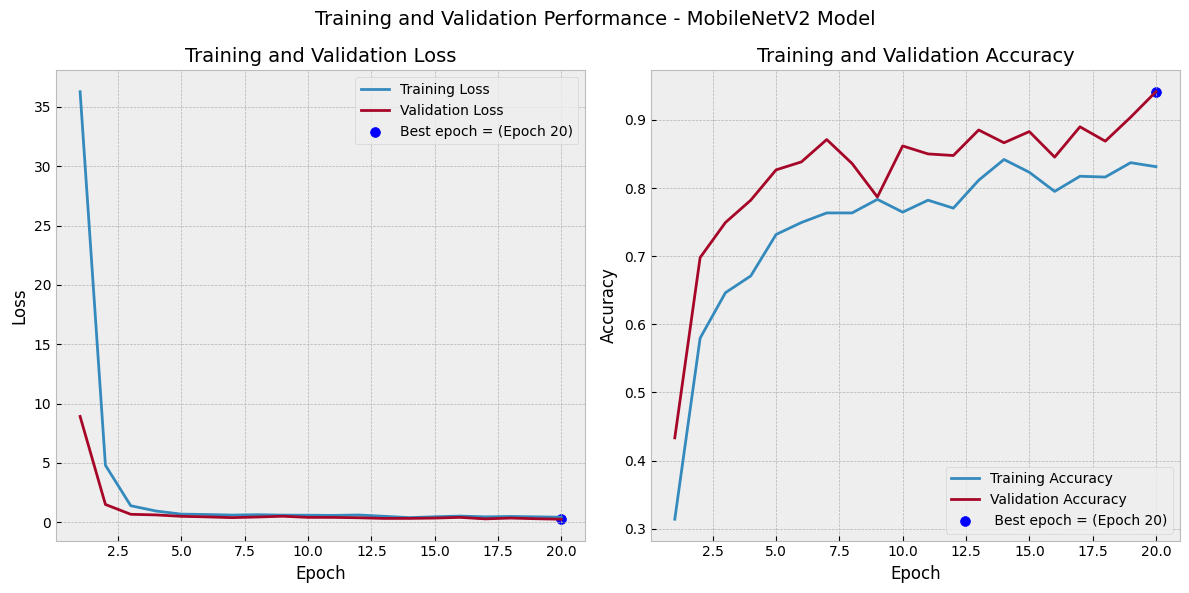

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns 
# Assuming history_DenseNet contains the training history
train_acc = history_mobile.history['accuracy']
train_loss = history_mobile.history['loss']
val_acc = history_mobile.history['val_accuracy']
val_loss = history_mobile.history['val_loss']

# Find best validation points
best_val_loss_epoch = np.argmin(val_loss) + 1  # Add 1 for epoch number
best_val_acc_epoch = np.argmax(val_acc) + 1

epochs = range(1, len(train_acc) + 1)  # Create epochs list (starting from 1)

# Improved labels for markers
#marker_fontsize = 10
plt.rcParams['font.size'] = 10
loss_label = f'Best epoch = (Epoch {best_val_loss_epoch})'
acc_label = f' Best epoch = (Epoch {best_val_acc_epoch})'

# Plot training history
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.style.use('bmh')  # Optional style

plt.suptitle('Training and Validation Performance - MobileNetV2 Model', fontsize=14)
# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.scatter(best_val_loss_epoch, val_loss[best_val_loss_epoch - 1], s=50, c='blue', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.scatter(best_val_acc_epoch, val_acc[best_val_acc_epoch - 1], s=50, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
# Make predictions on the test data
predictions = model_MobileNet.predict(test_gen)

# Evaluate the model's performance on the test set
test_loss, test_accuracy = model_MobileNet.evaluate(test_gen)

# Print the evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')


14/14 [==============================] - 6s 428ms/step - loss: 0.3775 - accuracy: 0.8902
Test Loss: 0.3775, Accuracy: 0.8902


In [40]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# Get true labels (classes) from the data generator
y_true = test_gen.classes

# Make predictions on the test data
y_pred = model_MobileNet.predict(test_gen)

# Select the class with the highest probability for each prediction
y_pred = np.argmax(y_pred, axis=1)  # Extract class labels from predictions

# Create a dictionary mapping class indices to class names (assuming test_gen provides this information)
classes = dict(zip(test_gen.class_indices.values(), test_gen.class_indices.keys()))



14/14 [==============================] - 6s 425ms/step


In [41]:
classes = dict(zip(test_gen.class_indices.values(), test_gen.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_gen.labels))), 
                            "Test Labels" : test_gen.labels, 
                            "Test Classes" : [classes[i] for i in test_gen.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_gen.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model_MobileNet.predict(test_gen), axis = 1))]
                           })
Predictions.head(8)

14/14 [==============================] - 6s 420ms/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.861385
1,1,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.999990
2,2,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.773693
3,3,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.999999
4,4,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.842353
5,5,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.614535
6,6,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.616269
7,7,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.999992


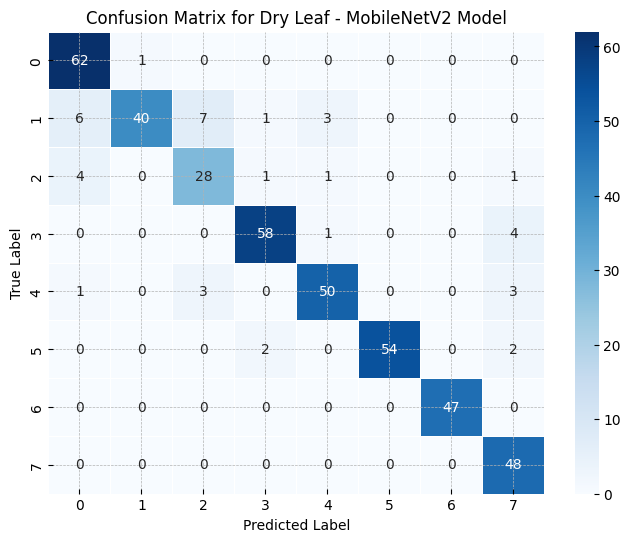

array([[62,  1,  0,  0,  0,  0,  0,  0],
       [ 6, 40,  7,  1,  3,  0,  0,  0],
       [ 4,  0, 28,  1,  1,  0,  0,  1],
       [ 0,  0,  0, 58,  1,  0,  0,  4],
       [ 1,  0,  3,  0, 50,  0,  0,  3],
       [ 0,  0,  0,  2,  0, 54,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 47,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 48]])

In [42]:
# Assuming you have y_test (true labels) and y_pred (predicted labels)
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues',  linewidths=0.5)

plt.xlabel('Predicted Label',fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.title('Confusion Matrix for Dry Leaf - MobileNetV2 Model',fontsize=12)
plt.show()

cm # from txt apperance

In [43]:
# Evaluate model performance
print("Classification Report - MobileNetV2")
print(classification_report(y_true, y_pred))

classification_report = classification_report(y_test, y_pred, output_dict=True)
# Access and format desired metrics
precision = classification_report['weighted avg']['precision']
recall = classification_report['weighted avg']['recall']
f1_score = classification_report['weighted avg']['f1-score']
accuracy = classification_report['accuracy']
print(f"Weighted Average Performance:\n")
print(f"Precision: {precision:.4f}")  # Format with 4 decimal places
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Classification Report - MobileNetV2
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        63
           1       0.98      0.70      0.82        57
           2       0.74      0.80      0.77        35
           3       0.94      0.92      0.93        63
           4       0.91      0.88      0.89        57
           5       1.00      0.93      0.96        58
           6       1.00      1.00      1.00        47
           7       0.83      1.00      0.91        48

    accuracy                           0.90       428
   macro avg       0.90      0.90      0.90       428
weighted avg       0.91      0.90      0.90       428

Weighted Average Performance:

Precision: 0.9121
Recall: 0.9042
F1-Score: 0.9032
Accuracy: 0.9042




<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">DenseNet201 Model</h2>
</center>


In [44]:
model_DenseNet =tf.keras.applications.DenseNet201(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
)
model_DenseNet.trainable = False
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = model_DenseNet(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(8,activation='softmax')(x)

model_DenseNet = tf.keras.Model(inputs=[input_layer],outputs=[output])
model_DenseNet.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_2 (Flatten)         (None, 94080)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              96338944  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 8)                 8200      
                                                            

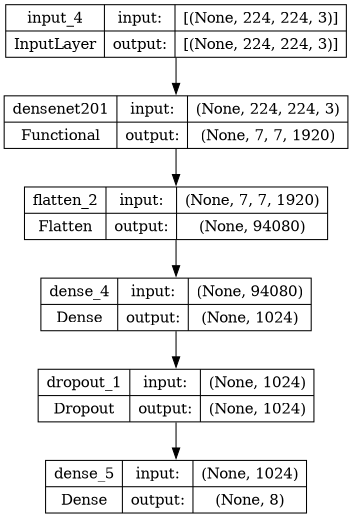

In [45]:
# Generate a visualization of the DenseNet201 model architecture
plot_model(model_DenseNet, to_file='model.png', 
           show_shapes=True, show_layer_names=True, 
           rankdir='TB', 
           dpi=75) # The resolution of the output image in dots per inch

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping callback 
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy for early stopping
    patience=20,  # Stop training if validation accuracy doesn't improve for 10 epochs
    verbose=1,  # Print a message at the end of each epoch
    restore_best_weights=True  # Restore best weights from the epoch with highest validation accuracy
)

# Define learning rate reduction callback with explanatory comments
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  # Monitor validation accuracy for learning rate reduction
    patience=20,  # Reduce learning rate if validation accuracy doesn't improve for 10 epochs
    verbose=1,  # Print a message at the end of each epoch
    factor=0.1,  # Reduce learning rate by 10% each time
    min_lr=0.00001,  # Set a minimum learning rate to prevent excessive reduction
    mode='max'  # Monitor for maximization (as we're interested in improving accuracy)
)

# Combine callbacks in a list
callbacks = [early_stopping, learning_rate_reduction]
model_DenseNet.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# Train the model for 20 epochs
num_epochs = 20

# Train the model using fit_generator with validation data and callbacks
history_DenseNet = model_DenseNet.fit(
    train_gen,
    epochs=num_epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
27/27 [==============================] - 45s 1s/step - loss: 22.4109 - accuracy: 0.3162 - val_loss: 2.6255 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - 20s 742ms/step - loss: 2.9885 - accuracy: 0.5855 - val_loss: 0.6697 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - 20s 744ms/step - loss: 0.7744 - accuracy: 0.7646 - val_loss: 0.3723 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 4/20
27/27 [==============================] - 20s 760ms/step - loss: 0.4641 - accuracy: 0.8337 - val_loss: 0.2193 - val_accuracy: 0.9344 - lr: 0.0010
Epoch 5/20
27/27 [==============================] - 20s 733ms/step - loss: 0.3224 - accuracy: 0.8806 - val_loss: 0.2077 - val_accuracy: 0.9274 - lr: 0.0010
Epoch 6/20
27/27 [==============================] - 20s 728ms/step - loss: 0.2670 - accuracy: 0.8946 - val_loss: 0.1785 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 7/20
27/27 [==============================] - 19s 702ms/step

In [48]:
#Save the DenseNet201 model
model_DenseNet.save("model_DenseNet.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




<center>
  <h2 style="
      color: #2c3e50;
      font-size: 24px;
      font-weight: normal;
      font-family: 'Arial', sans-serif;
      margin: 15px 0;
  ">Evaluation</h2>
</center>


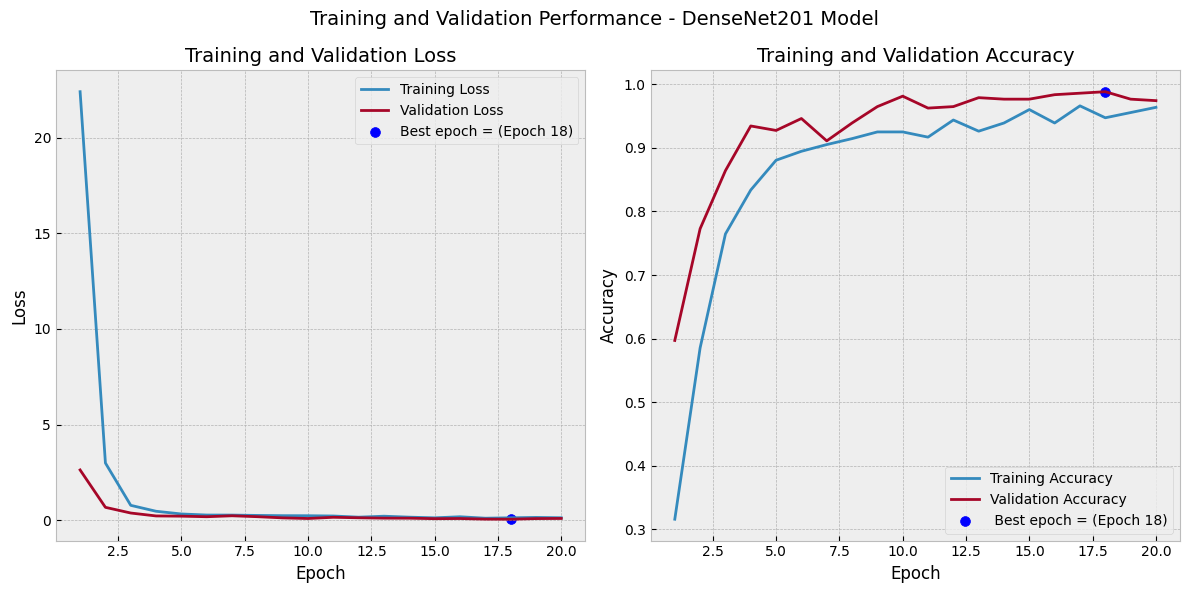

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns 
# Assuming history_DenseNet contains the training history
train_acc = history_DenseNet.history['accuracy']
train_loss = history_DenseNet.history['loss']
val_acc = history_DenseNet.history['val_accuracy']
val_loss = history_DenseNet.history['val_loss']

# Find best validation points
best_val_loss_epoch = np.argmin(val_loss) + 1  # Add 1 for epoch number
best_val_acc_epoch = np.argmax(val_acc) + 1

epochs = range(1, len(train_acc) + 1)  # Create epochs list (starting from 1)

# Improved labels for markers
#marker_fontsize = 10
plt.rcParams['font.size'] = 10
loss_label = f'Best epoch = (Epoch {best_val_loss_epoch})'
acc_label = f' Best epoch = (Epoch {best_val_acc_epoch})'

# Plot training history
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.style.use('bmh')  # Optional style

plt.suptitle('Training and Validation Performance - DenseNet201 Model', fontsize=14)
# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.scatter(best_val_loss_epoch, val_loss[best_val_loss_epoch - 1], s=50, c='blue', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.scatter(best_val_acc_epoch, val_acc[best_val_acc_epoch - 1], s=50, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
# Make predictions on the test data
predictions = model_DenseNet.predict(test_gen)

# Evaluate the model's performance on the test set
test_loss, test_accuracy = model_DenseNet.evaluate(test_gen)

# Print the evaluation metrics
print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')


14/14 [==============================] - 6s 433ms/step - loss: 0.0717 - accuracy: 0.9860
Test Loss: 0.0717, Accuracy: 0.9860


In [51]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
# Get true labels (classes) from the data generator
y_true = test_gen.classes
# Make predictions on the test data
y_pred = model_DenseNet.predict(test_gen)
# Select the class with the highest probability for each prediction
y_pred = np.argmax(y_pred, axis=1)  # Extract class labels from predictions

14/14 [==============================] - 6s 419ms/step


In [52]:
classes = dict(zip(test_gen.class_indices.values(), test_gen.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_gen.labels))), 
                            "Test Labels" : test_gen.labels, 
                            "Test Classes" : [classes[i] for i in test_gen.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_gen.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model_DenseNet.predict(test_gen), axis = 1))]
                           })
Predictions.head(8)

14/14 [==============================] - 6s 419ms/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,1.000000
1,1,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,5,MG_OD_BOP1 - Cup Colour_Little Plain_Lacking S...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,1.000000
2,2,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.994289
3,3,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,1.000000
4,4,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.985879
5,5,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.989822
6,6,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,4,LG_OD_OP1_Cup Colour_Fair Coloury_Fair Strengt...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,0.919591
7,7,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,6,MG_OD_BOPF - Cup Colour_Coloury_Fair Strength...,/kaggle/input/liquor-cnn-densenet201-mobilenet...,1.000000


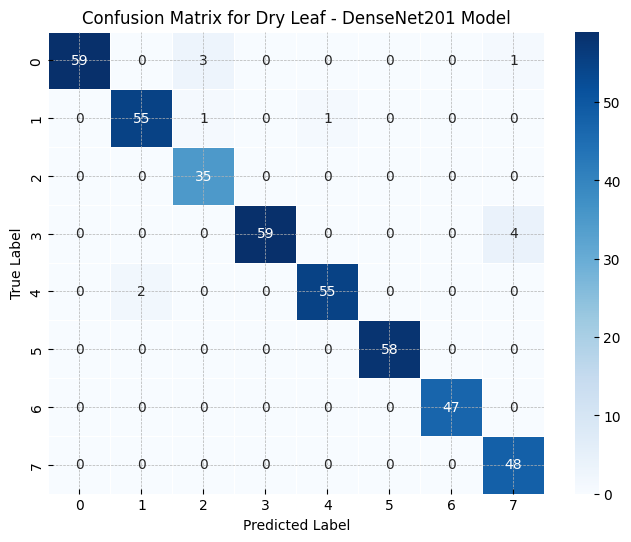

array([[59,  0,  3,  0,  0,  0,  0,  1],
       [ 0, 55,  1,  0,  1,  0,  0,  0],
       [ 0,  0, 35,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 59,  0,  0,  0,  4],
       [ 0,  2,  0,  0, 55,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 58,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 47,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 48]])

In [53]:
# Assuming you have y_test (true labels) and y_pred (predicted labels)
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues',  linewidths=0.5)

plt.xlabel('Predicted Label',fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.title('Confusion Matrix for Dry Leaf - DenseNet201 Model',fontsize=12)
plt.show()

cm # from txt apperancecm = confusion_matrix(y_test,y_pred)

In [54]:
# Evaluate model performance
print("Classification Report:")
print(classification_report(y_true, y_pred))

classification_report = classification_report(y_test, y_pred, output_dict=True)
# Access and format desired metrics
precision = classification_report['weighted avg']['precision']
recall = classification_report['weighted avg']['recall']
f1_score = classification_report['weighted avg']['f1-score']
accuracy = classification_report['accuracy']
print(f"Weighted Average Performance:\n")
print(f"Precision: {precision:.4f}")  # Format with 4 decimal places
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        63
           1       0.96      0.96      0.96        57
           2       0.90      1.00      0.95        35
           3       1.00      0.94      0.97        63
           4       0.98      0.96      0.97        57
           5       1.00      1.00      1.00        58
           6       1.00      1.00      1.00        47
           7       0.91      1.00      0.95        48

    accuracy                           0.97       428
   macro avg       0.97      0.98      0.97       428
weighted avg       0.97      0.97      0.97       428

Weighted Average Performance:

Precision: 0.9740
Recall: 0.9720
F1-Score: 0.9722
Accuracy: 0.9720
